In [1]:
import numpy as np
import pandas as pd
import pydataset as data
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import titanic_cleaning

import warnings
warnings.filterwarnings("ignore")

# 1) select data set: Zillow

In [2]:
df = wrangle.wrangle_zillow()

In [3]:
df.head()

,bed_rms,bath_rms,sq_ft,tax_value,yr_blt,taxamount,fips
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,6037.0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,6037.0


# 2) Prepare data

In [4]:
df = wrangle.remove_human_outliers(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126595 entries, 4 to 2152862
Data columns (total 7 columns):
 #   Column     Dtype  
---  ------     -----  
 0   bed_rms    float64
 1   bath_rms   float64
 2   sq_ft      float64
 3   tax_value  float64
 4   yr_blt     float64
 5   taxamount  float64
 6   fips       float64
dtypes: float64(7)
memory usage: 129.8 MB


In [6]:
train, validate, test = wrangle.split_data(df)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1190893 entries, 976303 to 248886
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   bed_rms    1190893 non-null  float64
 1   bath_rms   1190893 non-null  float64
 2   sq_ft      1190893 non-null  float64
 3   tax_value  1190893 non-null  float64
 4   yr_blt     1190893 non-null  float64
 5   taxamount  1190893 non-null  float64
 6   fips       1190893 non-null  float64
dtypes: float64(7)
memory usage: 72.7 MB


In [8]:
train = train.sample(frac = 0.5)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595446 entries, 71579 to 1995548
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   bed_rms    595446 non-null  float64
 1   bath_rms   595446 non-null  float64
 2   sq_ft      595446 non-null  float64
 3   tax_value  595446 non-null  float64
 4   yr_blt     595446 non-null  float64
 5   taxamount  595446 non-null  float64
 6   fips       595446 non-null  float64
dtypes: float64(7)
memory usage: 36.3 MB


In [10]:
train.drop(columns=['taxamount'], inplace = True)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595446 entries, 71579 to 1995548
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   bed_rms    595446 non-null  float64
 1   bath_rms   595446 non-null  float64
 2   sq_ft      595446 non-null  float64
 3   tax_value  595446 non-null  float64
 4   yr_blt     595446 non-null  float64
 5   fips       595446 non-null  float64
dtypes: float64(6)
memory usage: 31.8 MB


# 3) Work through all the steps

In [12]:
train.tax_value.mean()

442539.47228967864

In [13]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510383 entries, 678208 to 237299
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   bed_rms    510383 non-null  float64
 1   bath_rms   510383 non-null  float64
 2   sq_ft      510383 non-null  float64
 3   tax_value  510383 non-null  float64
 4   yr_blt     510383 non-null  float64
 5   taxamount  510383 non-null  float64
 6   fips       510383 non-null  float64
dtypes: float64(7)
memory usage: 31.2 MB


In [14]:
X_cols = ['bed_rms', 'bath_rms', 'sq_ft', 'yr_blt', 'fips']

In [15]:
# split data into X and y
X_train = train[X_cols]
y_train = train.tax_value

X_validate = validate[X_cols]
y_validate = validate.tax_value

X_test = test[X_cols]
y_test = test.tax_value

### Baseline

In [16]:
# creating data frames for y_train and y_validate
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
                    
    
# Predict tax_value_mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean']= tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# Predict tax_value median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  526065.54 
Validate/Out-of-Sample:  536175.54
RMSE using Median
Train/In-Sample:  538578.75 
Validate/Out-of-Sample:  548640.16


### Viz for Baseline

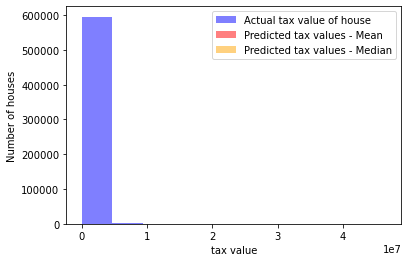

In [34]:
# plot to visualize actual vs predicted. 

plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual tax value of house")
plt.hist(y_train.tax_value_pred_mean, color='red', alpha=.5, label="Predicted tax values - Mean")
plt.hist(y_train.tax_value_pred_median, color='orange', alpha=.5, label="Predicted tax values - Median")
plt.xlabel("tax value")
plt.ylabel("Number of houses")
plt.legend()
plt.show()


In [18]:
tax_value_pred_mean

442539.47228967864

In [19]:
tax_value_pred_median

327118.0

### OLS Model

In [20]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for OLS using LinearRegression
Training/In-Sample:  425734.23094901326 
Validation/Out-of-Sample:  433713.26969278173


### Polynomial Regression Model

In [21]:
# setting features

# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)


In [22]:
# Linear Regression

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm2)**(1/2)

# predict validate
y_validate['tax_value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  411430.39636246616 
Validation/Out-of-Sample:  418696.08556005673


In [23]:
# trying again with degree 4

# setting features

# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree4 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree4 = pf.transform(X_validate)
X_test_degree4 = pf.transform(X_test)

In [24]:
# Linear Regression

# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm4.fit(X_train_degree4, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm4'] = lm4.predict(X_train_degree4)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm4)**(1/2)

# predict validate
y_validate['tax_value_pred_lm4'] = lm4.predict(X_validate_degree4)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm4)**(1/2)

print("RMSE for Polynomial Model, degrees=4\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)



RMSE for Polynomial Model, degrees=4
Training/In-Sample:  404366.64039439533 
Validation/Out-of-Sample:  420215.7767350579


### Lasso Lars Model

In [25]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  425740.49428513274 
Validation/Out-of-Sample:  433735.29309771815


### GLM

In [26]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  526065.5442413893 
Validation/Out-of-Sample:  536175.5380789593


## Evaluation

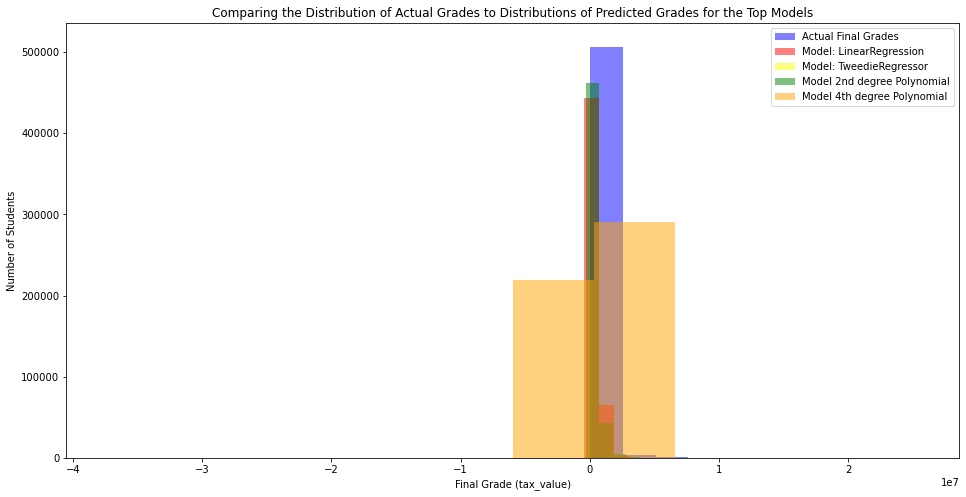

In [32]:
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Final Grades")
plt.hist(y_validate.tax_value_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.hist(y_validate.tax_value_pred_lm4, color = 'orange', alpha =.5, label= 'Model 4th degree Polynomial')
plt.xlabel("Final Grade (tax_value)")
plt.ylabel("Number of Students")
plt.title("Comparing the Distribution of Actual Grades to Distributions of Predicted Grades for the Top Models")
plt.legend()
plt.show()


In [28]:
y_validate.head()

,tax_value,tax_value_pred_mean,tax_value_pred_median,tax_value_pred_lm,tax_value_pred_lm2,tax_value_pred_lm4,tax_value_pred_lars,tax_value_pred_glm
678208,347000.0,442539.47229,327118.0,535614.592061,463877.952255,436232.0,530998.179458,442539.47229
1017832,59384.0,442539.47229,327118.0,218606.159422,239501.279100,261800.0,218314.567289,442539.47229
826666,305482.0,442539.47229,327118.0,136985.536775,299175.204932,311464.0,139613.021701,442539.47229
1183333,122033.0,442539.47229,327118.0,376157.180219,423889.469383,466480.0,379174.805579,442539.47229
1966872,177849.0,442539.47229,327118.0,281144.436867,296331.111304,306016.0,280240.415161,442539.47229


# I hate all of this. I'm going to start over

In [29]:
import numpy as np
import pandas as pd
import pydataset as data
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle

import warnings
warnings.filterwarnings("ignore")

In [30]:
df = wrangle.wrangle_zillow()

In [31]:
df = wrangle.remove_human_outliers(df)
train, validate, test = wrangle.split_data(df)
train = train.sample(frac = 0.5)
train.drop(columns=['taxamount'], inplace = True)